In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

from tempo.models import NewTempoLinear
from tempo.data.datasets import finetune_dataset2

from torchvision.transforms import Normalize

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

In [2]:
normalize = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

In [3]:
# load models
weights_tp = torch.load('../model_zoo/top_dog10.pth')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
_ = model_bl.eval()

In [4]:
def test_model(model, testloader, device):

    wrongly_classified = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels = data
        total = inputs.shape[0]
        inputs, labels = normalize(inputs), labels

        with torch.no_grad():
            preds = model(inputs).argmax(dim=1)

        wrong = (total - (preds == labels).sum()).item()
        wrongly_classified += wrong

    return 1 - (wrongly_classified / len(testloader.dataset))

In [5]:
test_loader = finetune_dataset2(train=False, batch_size=10)

In [6]:
test_model(model_tp, test_loader, 'cpu')

0.975

In [7]:
test_model(model_bl, test_loader, 'cpu')

0.825

## Confusion Matrices

In [8]:
def get_conf_matrix(model: nn.Module, test_loader: DataLoader):
    targets = []
    predictions = []

    for images, labels in test_loader:
        
        images = normalize(images)

        with torch.no_grad():
            preds = model(images).argmax(dim=1)

        targets += labels.tolist()
        predictions += preds.tolist()

    conf_matrix = confusion_matrix(targets, predictions, labels=np.arange(24))

    df_cm = pd.DataFrame(conf_matrix, index = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"],
                                    columns = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"])

    sn.heatmap(df_cm, annot=True)

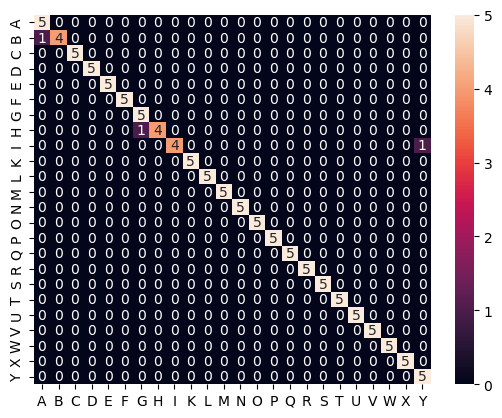

In [9]:
get_conf_matrix(model_tp, test_loader)

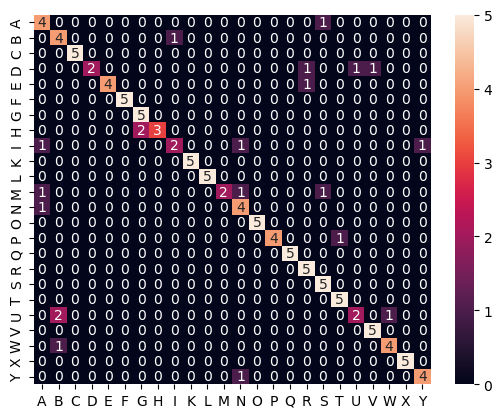

In [10]:
get_conf_matrix(model_bl, test_loader)